In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
import numpy as np
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
import scipy.stats as st
plt.style.use('seaborn-talk')

In [18]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

We need to drop NMHC(GT) since 90% of this column is -200(Vacancy value)

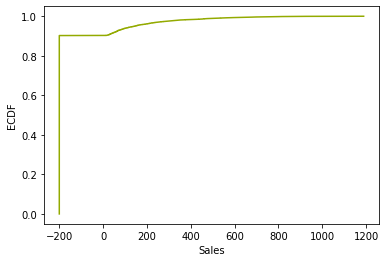

In [20]:
cdf = ECDF(data['NMHC(GT)'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = "#93AA00");
plt.xlabel('Sales'); plt.ylabel('ECDF');

Remove vacancy values

In [35]:
Frame = pd.DataFrame(data,columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)',
                                  'NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)'])
for row in list(Frame):
    for index,row_d in df.iterrows():
        if(Frame[row][index] == -200):
            m=1
            while(Frame[row][index+m] == -200):
                m+=1
            Frame[row][index] = (Frame[row][index-1]+Frame[row][index+m])/2

Feature engineering, since it can be seen as a surpvised problem, all time-dependent information should be added as a feature

In [47]:
Frame['TIME'] = Frame.index.hour
Frame['DATE'] = Frame.index.day
Frame['MONTH'] = Frame.index.month
Frame['WEEKEND'] = 0
for x in Frame.index:
    if x.dayofweek in [5,6]:
        Frame.loc[x,"WEEKEND"] = 1

Split the data into train/test set

In [55]:
Y = Frame['PT08.S5(O3)']
X = Frame.drop('PT08.S5(O3)',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [56]:
print(X_train.shape,y_train.shape)

(6549, 12) (6549,)


In [57]:
params = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42} 
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train,y_train)

[15:39:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [58]:
#Here learning rate is eta in xgboost
params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}
search_sk = RandomizedSearchCV(xgb_model, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)
print(search_sk.best_params_); print(search_sk.best_score_)

[15:40:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:49] WARNI

[15:45:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'gamma': 5.29599795317932, 'learning_rate': 0.08226193120343446, 'max_depth': 10, 'reg_alpha': 66.03855122263164}
0.9563791309037232


In [73]:
para_suit = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta':0.08226193120343446,
    'gamma':5.29599795317932,
    'max_depth':10,
    'reg_alpha':66.03855122263164,
}

train_xgb = xgb.DMatrix(X_train,y_train)

model_final = xgb.train(para_suit,train_xgb, 300, verbose_eval = True)

In [77]:
dtest = xgb.DMatrix(X_test)
prediction = model_final.predict(dtest)

In [132]:
print(y_test.values[0])

894.75


In [134]:
sum = 0
for x,y in zip(prediction,y_test.values):
    sum += (x-y)**2
RMSE = (sum/len(prediction))**0.5

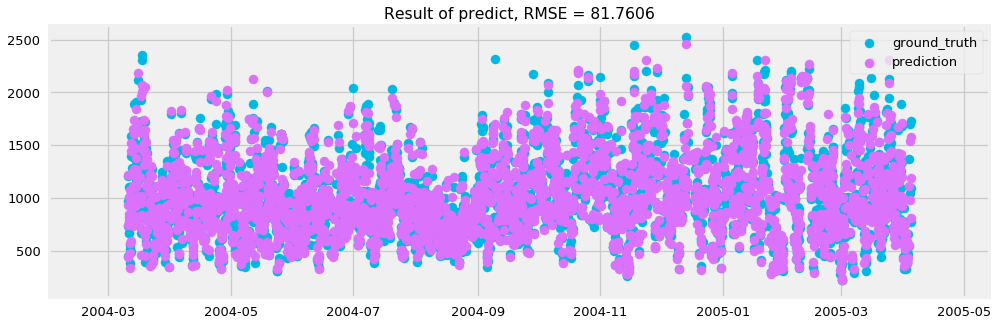

In [138]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
prediction_frame = pd.DataFrame(data=prediction,index=y_test.index)
plt.figure(facecolor = 'white',figsize=(15,5))
plt.scatter(y_test.index,y_test,c = "#00B9E3",label = "ground_truth",)
plt.scatter(y_test.index,prediction_frame,c = "#DB72FB",label = "prediction",)
plt.legend(loc='best')
plt.title('Result of predict, RMSE = %.4f'% RMSE)
plt.show()

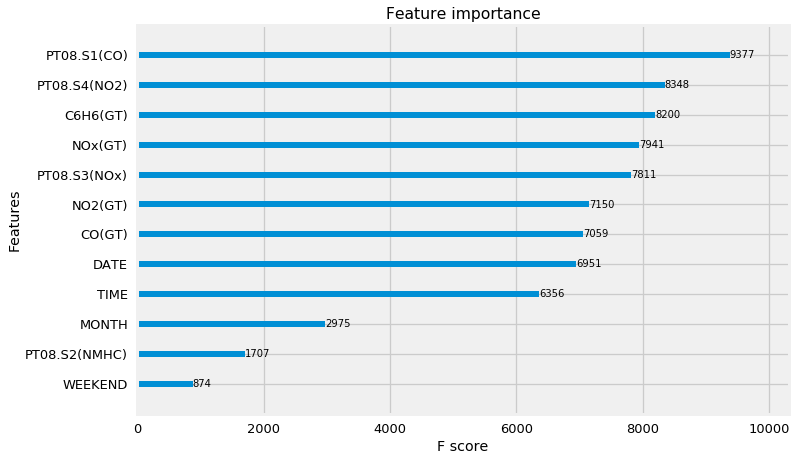

In [139]:
xgb.plot_importance(model_final,)